# Raw Training Data Creation

This notebook is responsible to load data from the given training data directory and then convert the data into a format based on numbers in vector form to represent tha features for each given training example. The goal of this notebook is to make sure that there is code to convert the data from the given .wav files into a big Train/Test feature matriz and class labels target vector.

### Importing Libraries

Importing the required libraries for the notebook

In [83]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.io import wavfile
from typing import List

### Helper Function Definitions

This section will define several helper functions to help load the data and convert them into a feature matrix along with a class label target vector

In [64]:
def exist_directory(directory_path: str):
    return os.path.isdir(directory_path)

def exist_file(file_path: str):
    return os.path.isfile(file_path)

def get_directory_contents(directory_path: str, pattern: str):
    if exist_directory(directory_path):
        # Get the current working directory
        cwd = os.getcwd()
        # Change the directory into the target directory path
        os.chdir(directory_path)
        # Get the list of directory contents
        directory_contents = glob.glob(pattern)
        # Change back to the original process working directory
        os.chdir(cwd)
        # Return back the directory contents
        return directory_contents
    else:
        return []
    
def get_subdirectory_names(directory_path: str):
    return list(map(lambda subdirectory_name: subdirectory_name.replace('\\', '').replace('//', ''),
                    get_directory_contents(directory_path, '*//')))

def get_file_names(directory_path: str, file_extension: str):
    return get_directory_contents(directory_path, f'*{file_extension}')

def construct_path(directory_path: str, directory_content_name: str):
    return os.path.join(directory_path, directory_content_name)

### Wav File Reader Functions

This section of the notebook is responsible to define various functions that will provide the necessary data about the sound signals from the given input wavfile

In [95]:
def read_wav_file(file_path: str):
    if exist_file(file_path):
        return wavfile.read(file_path)
    else:
        return (44100, np.array([]))
    
def get_sound_signals(wav_file_data):
    return wav_file_data[-1]

def normalize_sound_signals(sound_signals: np.array):
    return np.float16(sound_signals / (2. ** 15))

def get_left_channel_data(sound_signals: np.array):
    return sound_signals[:, 0]

def get_right_channel_data(sound_signals: np.array):
    return sound_signals[:, -1]

def get_sound_feature_vectors_from_file(file_path: str):
    sound_signals = normalize_sound_signals(get_sound_signals(read_wav_file(file_path)))
    left_channel_feature_vector, right_channel_feature_vector = \
        get_left_channel_data(sound_signals), get_right_channel_data(sound_signals)
    return left_channel_feature_vector, right_channel_feature_vector

### Class Data Loader

This section is responsible to load features from each wav file belonging to a particular class and returning a feature matrix along with the traget class label.

In [66]:
def stack_data(feature_matrix: np.array, left_channel_features: np.array, right_channel_features: np.array):
    if len(feature_matrix) == 0:
        return np.stack((left_channel_features, right_channel_features))
    else:
        return np.vstack((feature_matrix, left_channel_features, right_channel_features))

def get_class_data(parent_directory_path: str, class_label: str):
    # Initializing the class feature matrix and target vector
    class_feature_matrix = []
    class_target_vector = []
    # Construct the path
    class_directory_path = construct_path(parent_directory_path, class_label)
    # Make sure the given path is correct
    if not exist_directory(class_directory_path):
        return np.array(class_feature_matrix), np.array(class_target_vector)
    
    # Get the names of the wav file belonging to the current class
    wav_file_names = get_file_names(class_directory_path, '.wav')
    print(f'Processing: {len(wav_file_names)} files')
    # Iterate through each wav file
    for file_name in wav_file_names:
        file_path = construct_path(class_directory_path, file_name)
        left_channel_features, right_channel_features = get_sound_feature_vectors_from_file(file_path)
        #class_feature_matrix = stack_data(class_feature_matrix, left_channel_features, right_channel_features)
        class_feature_matrix += [left_channel_features, right_channel_features]
        class_target_vector += [class_label]*2
        
    return np.array(class_feature_matrix), np.array(class_target_vector)

### Training Data Loader

This section is responsible to return the full training data from the training directory

In [84]:
def load_irmas_data(parent_directory_path: str, class_labels_to_process: List[str]):
    if not exist_directory(parent_directory_path):
        print(f'Invalid directory: {parent_directory_path}')
    
    class_labels = class_labels_to_process if class_labels_to_process else get_subdirectory_names(parent_directory_path)
    
    feature_matrix = np.array([])
    target_vector = np.array([])
    
    for class_label in class_labels:
        print(f'Getting Data from {class_label}')
        class_feature_matrix, class_target_vector = get_class_data(parent_directory_path, class_label)
        print(f'Loaded all the data from the class')
        if feature_matrix.size:
            feature_matrix = np.vstack((feature_matrix, class_feature_matrix))
            target_vector = np.hstack((target_vector, class_target_vector))
        else:
            feature_matrix = class_feature_matrix
            target_vector = class_target_vector
    
    return feature_matrix, target_vector

In [96]:
%%time
X_train, y_train = load_irmas_data(f'../../data/whole_dataset/training/', ['cel', 'cla'])

Getting Data from cel
Processing: 388 files
Loaded all the data from the class
Getting Data from cla
Processing: 505 files
Loaded all the data from the class
Wall time: 17 s


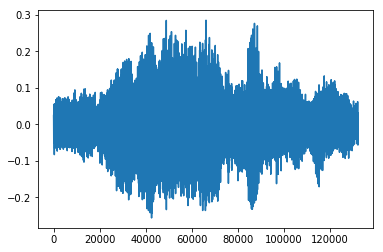

In [120]:
plt.plot(X_train[1010])